This notebook shows 
* computing activity detections for some directory of temporally sequential sequence of images for some fixed window with some stride, caching serialized results.
* plot interactive figures to see model prediction results over time for specific classes we have ground truth for.
 
Initial data used and explored with this notebook is located on Google Drive [here](https://drive.google.com/drive/folders/1hvqQKT5om5xiXn1l_mwFJfPYNJ6oi4aQ).
* Example ground truth file is the `pouring_water_v2.csv` file.
* Imagery is located under the `images` folder.

Additional dependencies needed are detailed in the `./additional_requirements.txt` file and should be installed prior to running this notebook.
* If dependencies were installed after starting jupyter-lab, the use of widgets in jupyter-lab enabled by the `ipympl` package requires a restart of jupyter-lab for the extension to become active.

`ffmpeg` is required for GIF generation later so that should be installed via whatever system mechanism is available/preferred.

---

Import notebook dependencies.

In [1]:
from angel_system.impls.detect_activities.swinb.swinb_detect_activities import SwinBTransformer
from collections import defaultdict
import concurrent.futures
import csv
from IPython.display import HTML, display
from pathlib import Path
import numpy as np
import pickle
import PIL.Image
import tqdm

In [2]:
# Paths to various things. These may be different for different people's systems.

# Model files for SwinB model should be populated by ansible. See top-level README.
SWINB_MODEL_CHECKPOINT = "../../model_files/swinb_model_stage_base_ckpt_6.pth"
SWINB_MODEL_LABELS = "../../model_files/swinb_coffee_task_labels.txt"
SWINB_MODEL_LABEL_COUNT = 14

# Directory of temporally sequential image files. Currently assuming the file names are
# in the format that would be output by the bag exploding tool, e.g. have the time-stamps
# in the filename in a specific format. See the `RE_FILENAME_TIME` regex and the `time_from_name`
# function. Explode your own bag or refer to the above mentioned Google drive example data.
IMAGES_DIR_PATH = Path("../../../experiment_activity_detector_window_sensitivity/exploded_bag/images")

# Ground truth file that that indicates spans of time that an activity begins and ends.
# See the `pouring_water_v2.csv` file in the above linked Google Drive location for the currently expected format.
TRUTH_CSV_PATH = Path("../../../experiment_activity_detector_window_sensitivity/pouring_water_v2.csv")

In [3]:
# Importing support functionality in the local python script.
# Various methods that are used in this notebook are defined
# there in an attempt to offload code volume out of this notebook.
from support_functions import (
    RE_FILENAME_TIME,
    time_from_name,
    frames_for_range,
    SliceResult,
    GlobalValues,
    SelectedSlice,
    plot_activity_confidence,
    animate_frame_sequence,
)

In [4]:
detector = SwinBTransformer(
    checkpoint_path=SWINB_MODEL_CHECKPOINT,
    num_classes=SWINB_MODEL_LABEL_COUNT,
    labels_file=SWINB_MODEL_LABELS,
    num_frames=32,
    sampling_rate=2,
    torch_device="cuda:0",
)

# This model has a specific input frame quantity requirement.
frame_input_size = 32 * 2  # 64

---

This block of cells will load all image matrices into memory and then compute activity prediction results for the parameterized window stride.

This may take up quite a bit of RAM depending on your data-set size.
In the future this could be optimized to not load *all* imagery in at once, but things are currently in a simple state.

The first cell below are some parameters to control the window stride we predict activities over and the cache file to save to.
We provide two examples to start: complete stride coverage (stride=1) and abutting windows (stride=window).

Additionally, optional functionality at the end of this block can filter the data to only retain slice predictions following some filtering logic: `Only retain a window prediction if the preceeding X window predictions for a class were all above a given threshold Y`. The parameters for this logic are in the cell below and begin with `HYST_`. To enable this filtering, set `HYST_ENABLE` to `True`.

**NOTE**: There is a little hack in the second-to-last cell of this block that is specifically for the dataset provided by the above Google Drive link that cuts off some of the data-set that is extraneous (the ground truth file does not appropriately cover). If using your own dataset, set the below `USE_DATASET_CUTOFF_HACK` to `False`.

In [5]:
window_stride = 1  # All possible frame-windows within the frame-range.
save_file = Path("./slice_prediction_results_swinb-all_windows.pkl")

# window_stride = frame_input_size  # Only abutting frame segments.
# save_file = Path("./slice_prediction_results_swinb-abutting_windows.pkl")

HYST_ENABLE = False
HYST_HISTORY_SIZE = 75
HYST_CONFIDENCE_THRESHOLD = 0.75

USE_DATASET_CUTOFF_HACK = True

In [6]:
# Sort lexicographically to get into temporal order.
GlobalValues.all_image_files = sorted(IMAGES_DIR_PATH.iterdir())
GlobalValues.all_image_mats = []

with concurrent.futures.ThreadPoolExecutor() as pool:
    for r in tqdm.tqdm(pool.map(lambda p: np.asarray(PIL.Image.open(p)), GlobalValues.all_image_files), 
                       total=len(GlobalValues.all_image_files), ncols=100):
        GlobalValues.all_image_mats.append(r)

GlobalValues.all_image_mats = np.asarray(GlobalValues.all_image_mats)

100%|██████████████████████████████████████████████████████████| 7236/7236 [00:31<00:00, 232.48it/s]


In [7]:
GlobalValues.all_image_times = np.asarray([
    time_from_name(p.name) for p in GlobalValues.all_image_files
])

assert len(GlobalValues.all_image_files) == len(GlobalValues.all_image_mats) == len(GlobalValues.all_image_times)

In [8]:
# Detector for every 64-frame chunk, collecting slice prediction results per class.
GlobalValues.clear_slice_values()


def gen_results(i):
    """ Generate results for one slice of frames. """
    j = i + frame_input_size
    return SliceResult(
        (i, j),
        (time_from_name(GlobalValues.all_image_files[i].name),
         time_from_name(GlobalValues.all_image_files[j].name)),
        detector.detect_activities(GlobalValues.all_image_mats[i:i+frame_input_size])
    )


if not save_file.is_file():
    inputs = list(range(0, GlobalValues.all_image_mats.shape[0] - frame_input_size, window_stride))
    
    # # -- Serial version --
    # for slice_result in tqdm.tqdm(map(gen_results, inputs),
    #                    total=len(inputs),
    #                    ncols=120):
    #         GlobalValues.slice_index_ranges.append(slice_result.index_range)
    #         GlobalValues.slice_time_ranges.append(slice_result.time_range)
    #         GlobalValues.slice_preds.append(slice_result.preds)
    
    # -- Threaded version --
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as pool:
        # Starting indices across the whole frame range.
        for slice_result in tqdm.tqdm(
            pool.map(gen_results, inputs),
            total=len(inputs),
            ncols=120
        ):
            GlobalValues.slice_index_ranges.append(slice_result.index_range)
            GlobalValues.slice_time_ranges.append(slice_result.time_range)
            GlobalValues.slice_preds.append(slice_result.preds)

    # Save results to disk, this took a while! (~1.5 hours)
    with open(save_file, 'wb') as ofile:
        pickle.dump({
            "slice_index_ranges": GlobalValues.slice_index_ranges,
            "slice_time_ranges": GlobalValues.slice_time_ranges,
            "slice_preds": GlobalValues.slice_preds,
        }, ofile, protocol=-1)
else:
    # We have a results file.
    # Load computed results
    print(f"Loading results from file: {save_file}")
    with open(save_file, 'rb') as f:
        results_dict = pickle.load(f)

    # The [start, end) frame index ranges per slice
    GlobalValues.slice_index_ranges = results_dict['slice_index_ranges']  # List[Tuple[int, int]]

    # The [start, end) frame time pairs
    GlobalValues.slice_time_ranges = results_dict['slice_time_ranges']  # List[Tuple[float, float]]

    # Prediction results per slice
    GlobalValues.slice_preds = results_dict['slice_preds']  # List[Dict[str, float]]


# HACK FOR THIS DATA-SET
# Filter out data past a certain point in time
if USE_DATASET_CUTOFF_HACK:
    end_idx = np.argwhere(np.asarray(GlobalValues.slice_time_ranges)[:,1] > (1657635528.1831903+10)).squeeze()[0]
    GlobalValues.slice_index_ranges = GlobalValues.slice_index_ranges[:end_idx]
    GlobalValues.slice_time_ranges = GlobalValues.slice_time_ranges[:end_idx]
    GlobalValues.slice_preds = GlobalValues.slice_preds[:end_idx]

Loading results from file: slice_prediction_results_swinb-all_windows.pkl


In [9]:
#
# Enable code to filter data by some temporal hysteresis
#
if HYST_ENABLE:
    confidence_threshold = 0.75

    # Create matrix of predictions for computational convenience
    raw_slice_preds = GlobalValues.slice_preds
    lbl_ref = list(raw_slice_preds[0].keys())
    # mat shape (nSlices x nClasses]
    slice_preds_mat = np.array([[slice_pred[lbl] for lbl in lbl_ref] for slice_pred in raw_slice_preds])

    # Scan predictions. If a prediction was not preceeded with `HYST_HISTORY_SIZE` predictions above `HYST_CONFIDENCE_THRESHOLD`, then we force the confidence to 0.
    new_slice_preds = []
    for i in range(len(GlobalValues.slice_index_ranges)):
        if i >= HYST_HISTORY_SIZE:
            hyst_preds = np.where(np.min(slice_preds_mat[i-HYST_HISTORY_SIZE:i+1], axis=0) > HYST_CONFIDENCE_THRESHOLD, slice_preds_mat[i], 0.)
            new_slice_preds.append({k: v for k, v in zip(lbl_ref, hyst_preds)})
        else:
            new_slice_preds.append({k: 0. for k in lbl_ref})

    slice_preds = new_slice_preds

---

In this block of cells, we will interactively plot activity detection prediction confidences over time per label of the model that we have ground truth for.

The plot is interactive in two ways:
1) On mouse hover over or near a plotted activity detection result will render an overlay pane that shows the still image corresponding to the time the plotted point is located.
   This effectively corresponds to the median frame of the imagery that went into the activity detector for prediction.
2) Clicking the mouse while there is an overlay rendered will cause that slice to be "selected" and for the animation of the prediction source frames to be rendered in the background.
   See the final three cells of this block to render and save the animation corresponding to the most recent click for each plot output.

The final loop in the next cell has some commented out final arguments for the `plot_activity_confidence` that would allow us to plot a custom width of time.
This has been used to indicate the specific temporal volume that went into a single activity prediction.

The final three cells here are used to render a composed GIF and save it to disk after having clicked on a prediction coordinate in one or more of the plots.

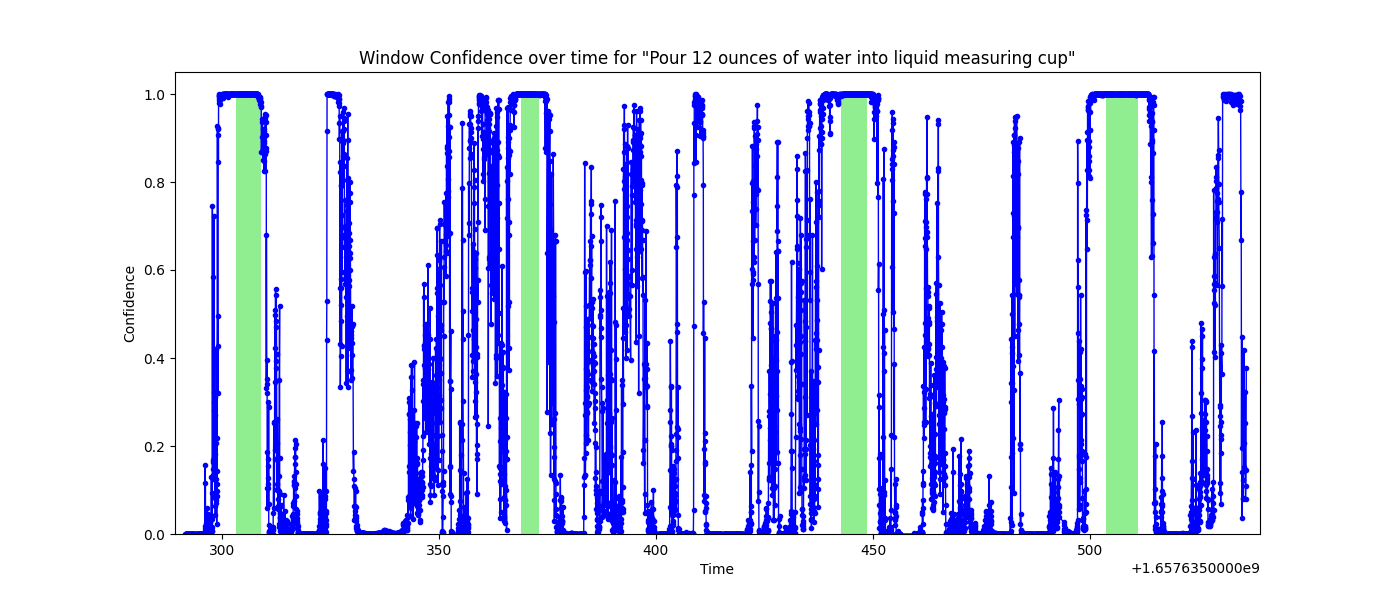

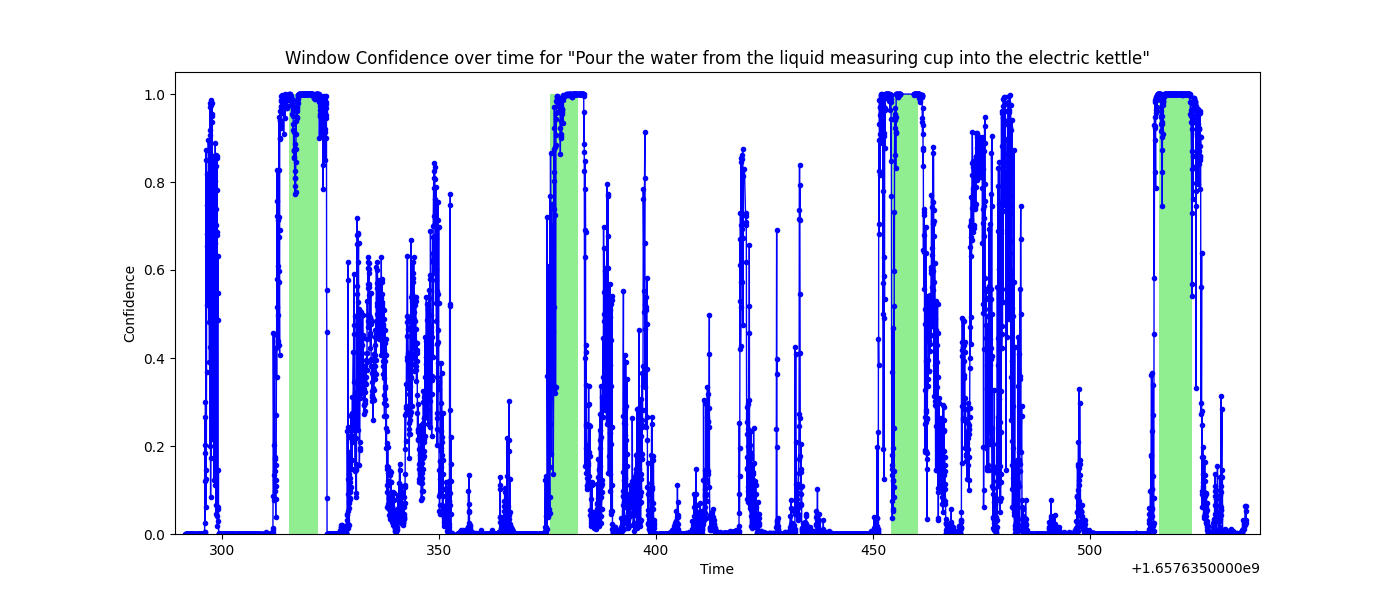

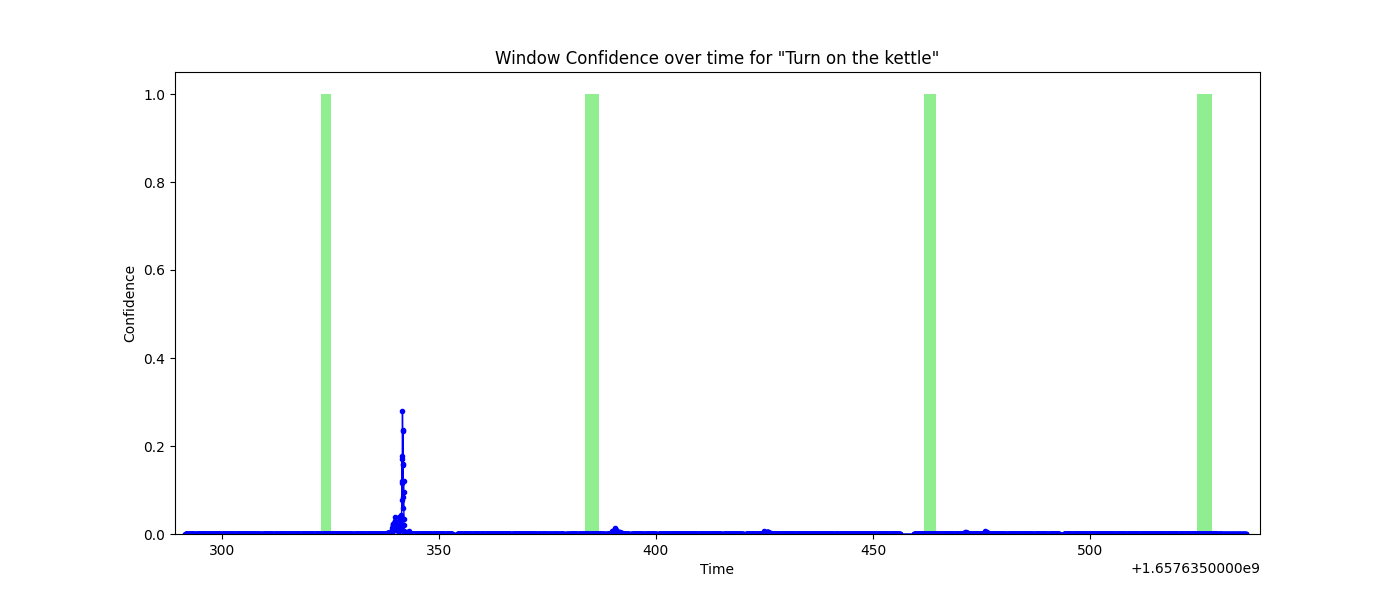

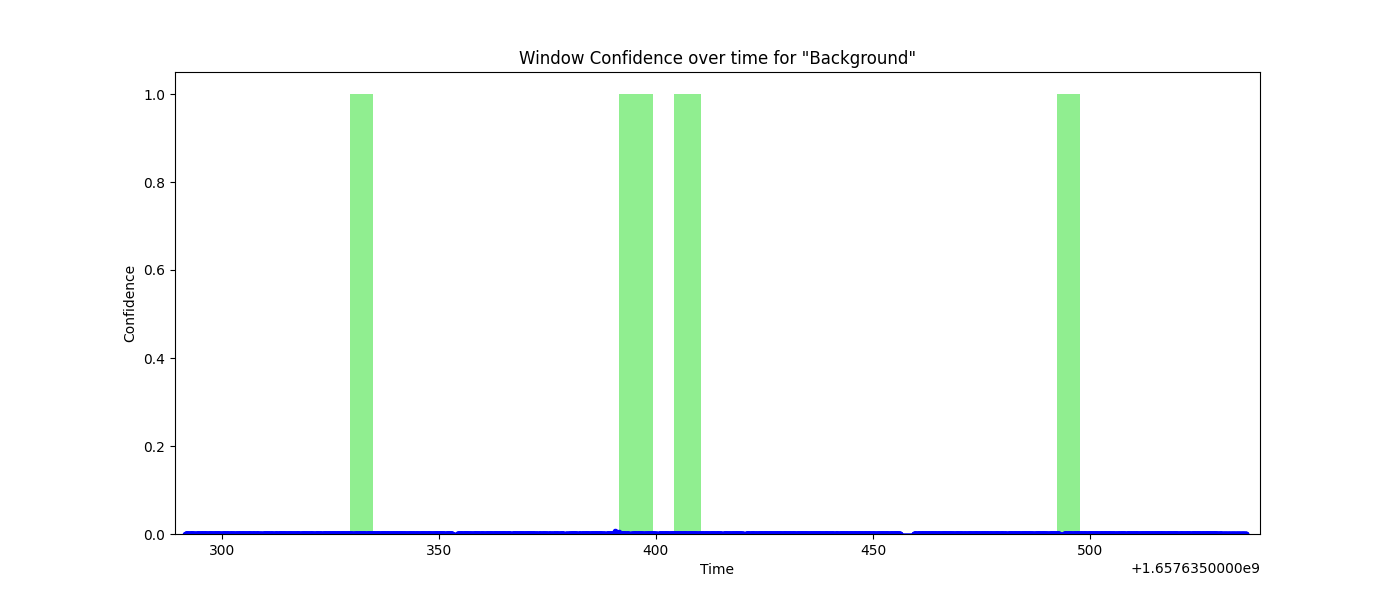

In [16]:
label_to_ts_ranges = defaultdict(list)
label_to_slice_handle = dict()

# for jupyter-lab support
%matplotlib widget
from support_functions import plot_activity_confidence, animate_frame_sequence


with open(TRUTH_CSV_PATH, 'r') as f:
    # IDs that have a starting event
    label_start_ts = dict()
    for row in csv.reader(f):
        if row[0].strip().startswith("#"):
            continue
        aid = row[0]
        label = row[9]
        if label not in label_start_ts:
            # "start" entry
            label_start_ts[label] = time_from_name(row[1])
        else:
            
            # "end" entry
            end_ts = time_from_name(row[1])
            label_to_ts_ranges[label].append((label_start_ts[label], end_ts))
            del label_start_ts[label]

for label, ts_range_pairs in label_to_ts_ranges.items():
    label_to_slice_handle[label] = plot_activity_confidence(label, ts_range_pairs,
                                                            # (1657635306.1710184, 1657635308.4670007)  # pour into cup, high confidence
                                                            # (1657635308.8698072, 1657635311.449707)  # pour into cup, lower confidence
                                                            # (1657635375.1021254, 1657635378.090638)  # pour into kettle, low confidence
                                                            # (1657635379.0608943, 1657635381.7726514)  # pout into kettle, high confidence
                                                            )

In [17]:
label_to_slice_handle

{'Pour 12 ounces of water into liquid measuring cup': SelectedSlice(index=None, animation=None),
 'Pour the water from the liquid measuring cup into the electric kettle': SelectedSlice(index=None, animation=None),
 'Turn on the kettle': SelectedSlice(index=None, animation=None),
 'Background': SelectedSlice(index=None, animation=None)}

In [18]:
for i, (label, handle) in enumerate(label_to_slice_handle.items()):
    if handle.animation is not None:
        display(f"Slice anination for label \"{label}\" -- Confidence: {handle.activity_predictions[label]}")
        display(HTML(handle.animation.to_html5_video()))
        # selected_slice.animation.save(f"./slice-{i}-{label}.gif")
    else:
        display(f"No slice selected for label \"{label}\"")

'No slice selected for label "Pour 12 ounces of water into liquid measuring cup"'

'No slice selected for label "Pour the water from the liquid measuring cup into the electric kettle"'

'No slice selected for label "Turn on the kettle"'

'No slice selected for label "Background"'

In [13]:
# Save GIFs where possible
for i, (label, handle) in enumerate(label_to_slice_handle.items()):
    if handle.animation is not None:
        display(f"Slice anination for label \"{label}\" -- Confidence: {handle.activity_predictions[label]}")
        # display(HTML(handle.animation.to_html5_video()))
        handle.animation.save(f"./slice-{i}-{label}.gif")
    else:
        display(f"No slice selected for label \"{label}\"")

'No slice selected for label "Pour 12 ounces of water into liquid measuring cup"'

'No slice selected for label "Pour the water from the liquid measuring cup into the electric kettle"'

'No slice selected for label "Turn on the kettle"'

'No slice selected for label "Background"'